# Agent-Based Model on Cat Behavior

### In our project we decided to create 4 total cats with several different traits ranging from hunger levels to personality traits
### Based on the traits each cat has will determine their interactions with each other, objects in the room, and people who walk in the room

In [1]:
from IPython.display import HTML
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time

To start here is a legend of all potential personality traits and needs our cats may have.

In [3]:
legend= {'Calm' : 'Very relaxed',
         'Clumsy' : 'Will tumble over and bump into things' ,
         'Shy' : 'Takes a while to warm up, might hide away' ,
         'Affectionate' : 'Loves cuddles' ,
         "Playful" : 'Wants to hunt and play' ,
         'Smart' : 'Learns quickly good at tricks' , 
         'Anxious' : 'Hides and paces around' , 
         'Angry' : 'Will hiss, growl, and bite' ,
         'Curious' : 'Adventurous and Engageful ' ,
         'Scared' : 'Will run away' ,
         'Energetic' : 'Will run around and play'} 

Because we want our interactions to be as random and organic as possible we will create a class that will help cat decisions!

In [5]:


class Cat:
    def __init__(self, name, personality, image_path):
        self.name = name
        self.personality = personality
        self.image_path = image_path
        self.activity = 'still'

        # physical needs
        self.sleep = 0
        self.hunger = 0
        self.potty = 0

        # position and motion
        self.x, self.y = random.randint(10, 140), random.randint(10, 140)
        self.speed = 0.5
        self.target = self.random_target()
        self.mood = "😐"

    def random_target(self):
        return (random.randint(10, 140), random.randint(10, 140))

    def update_traits(self):
        self.hunger += 1
        self.potty += 1
        self.sleep += 1

    def eat(self):
        self.hunger = 0
        self.potty += 2
        self.activity = "eat"

    def bed(self):
        self.sleep = max(0, self.sleep - 3)
        self.activity = "sleep"

    def play(self):
        self.hunger += 2
        self.sleep += 2
        self.potty += 1
        self.activity = "play"

    def bathroom(self):
        self.potty = 0
        self.activity = "bathroom"

    def action_choices(self):
        actions = {
            'eat': self.hunger,
            'sleep': self.sleep,
            'bathroom': self.potty,
            'play': self.personality.get('Playful', 1)
        }
        action = max(actions, key=actions.get)
        getattr(self, action)()

        

    def move_towards(self, target_x, target_y):
        dx = target_x - self.x
        dy = target_y - self.y
        dist = (dx**2 + dy**2)**0.5
        if dist > 0:
            self.x += self.speed * dx / dist
            self.y += self.speed * dy / dist
    def move(self):
        dx = self.target[0] - self.x
        dy = self.target[1] - self.y
        dist = (dx**2 + dy**2)**0.5
        if dist > 1:
            self.x += self.speed * dx / dist
            self.y += self.speed * dy / dist
            # Stay inside the plot area
            self.x = min(max(self.x, 0), 150)
            self.y = min(max(self.y, 0), 150)



    def roam(self):
        if self.mood == "😐":  # only roam if not interacting
            self.target = self.random_target()
    

    def distance_to(self, other):
        return ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5

    def interact_with(self, other_cat):
        distance = self.distance_to(other_cat)
    
        if distance < 25:
            shy = self.personality.get("Shy", 0)
            affectionate = self.personality.get("Affectionate", 0)
    
            if shy >= 4:
                self.mood = "🙀"
                # Move away from the other cat
                dx = self.x - other_cat.x
                dy = self.y - other_cat.y
                self.target = (self.x + dx, self.y + dy)
    
            elif affectionate >= 4:
                self.mood = "😻"
                self.target = (other_cat.x, other_cat.y)
    
            else:
                self.mood = "😺"
        else:
            self.mood = "😐"


    def __repr__(self):
        return f'Cat({self.name}), traits: {self.personality}'


In [7]:
cats = [ 
    Cat('Tito', {
        'Playful': 5, 'Affectionate': 4, 'Shy': 5, 'Calm': 2,
        'Curious': 3, 'Smart': 1, 'Hunger': 3, 'Sleep': 3, 'Scared': 4
    }, "tito.png"),

    Cat('Tobi', {
        'Playful': 3, 'Affectionate': 4, 'Shy': 1, 'Calm': 4,
        'Curious': 5, 'Smart': 3, 'Hunger': 3, 'Sleep': 3, 'Scared': 1
    }, "tobi.png"),

    Cat('Dumpling', {
        'Playful': 4, 'Affectionate': 5, 'Shy': 2, 'Calm': 3,
        'Curious': 4, 'Smart': 4, 'Hunger': 2, 'Sleep': 4, 'Scared': 2
    }, "dumpling.png"),

    Cat('Jiji', {
        'Playful': 2, 'Affectionate': 2, 'Shy': 4, 'Calm': 5,
        'Curious': 1, 'Smart': 5, 'Hunger': 4, 'Sleep': 2, 'Scared': 5
    }, "jiji.png")
]
        

Here you can find out who our cats are and what their personality traits are!

The start of the simulation for the visualization.

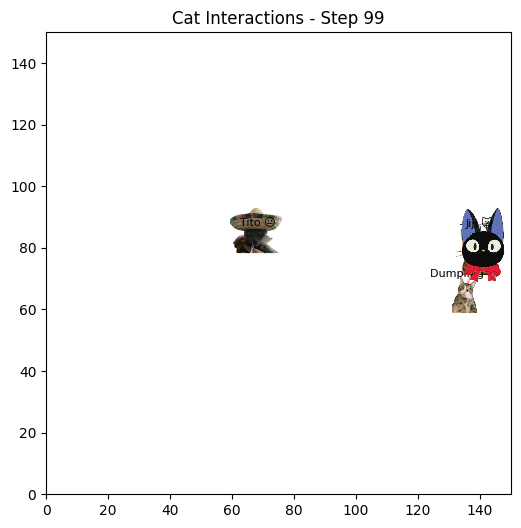

In [ ]:

import numpy as np
from PIL import Image
import imageio  # only if you're saving MP4s
frames = []
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

#The lines above are from Chatgpt!
# OpenAI. ChatGPT, 14 Apr. 2024, https://chat.openai.com.
# Prompt chain: { The orignal plotting code + "How do i save the display as a gif/mp4 file?"}

from IPython.display import display, clear_output
def imscatter(x, y, image_path, ax=None, zoom=0.25):
    if ax is None:
        ax = plt.gca()
    image = Image.open(image_path).convert("RGBA")
    image = np.asarray(image)
    im = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(im, (x, y), frameon=False)
    ax.add_artist(ab)
    return ab
    
#Visualization
fig, ax = plt.subplots(figsize=(6, 6))
canvas = FigureCanvas(fig)  # attach canvas to the figure. This line is from ChatGPT.

for step in range(100):
    ax.clear()
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 150)
    ax.set_title(f"Cat Interactions - Step {step}")

    for i in range(len(cats)):
        for j in range(i + 1, len(cats)):
            cats[i].interact_with(cats[j])
            cats[j].interact_with(cats[i])  # mutual!
    
    # Now move + roam based on updated moods
    for cat in cats:
        if cat.mood == "😐":
            cat.roam()
        cat.move()

        imscatter(cat.x, cat.y, cat.image_path, ax=ax, zoom=0.25)
        ax.text(cat.x, cat.y + 6, f"{cat.name} {cat.mood}", ha='center', fontsize=8)

    for i in range(len(cats)):
        for j in range(i + 1, len(cats)):
            if cats[i].distance_to(cats[j]) < 30:
                ax.plot([cats[i].x, cats[j].x], [cats[i].y, cats[j].y], 'r--', alpha=0.3)
    plt.draw()
    
    #Following lines are from CHatgpt!
    # Convert canvas to an RGBA image (handles latest versions)
    canvas.draw()  # make sure the figure is drawn
    image = np.array(canvas.buffer_rgba())  # get RGBA data
    image = image[:, :, :3]  # remove alpha channel (if you don't need it)
    frames.append(Image.fromarray(image))



    clear_output(wait=True)
    display(fig)
    time.sleep(0.05)
    
plt.close()

frames[0].save("cat_interactions2.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)



In [ ]:
#Human Class
class Human():
    def __init__(self, name, likeability, image_path):
        self.name = name
        self.likeness = likeability
        self.image_path = image_path

    def pet_cat(self, cat):
        # if cat.personality 
            # if affectionate is above 3, cat gets 1 pet. result is WHAT IS THE RESULT?
        pass



    def play_cat(self, cat):
    if cat.playful >= 3:
        #human can play with cat if cat playful is higher than 3
        #result is that WHWAT
        pass

    def feed_cat(self,cat):
        #If cat hunger level is below 5, cat will be fed....someone's code allows for the cat to 
        pass
        

In [ ]:
from IPython.display import HTML
import numpy as np  
import numpy.random as rand
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
# To start here is a legend of all potential personality traits and needs our cats may have.

legend= {'Calm' : 'Very relaxed; Gets along with all cats; Gets along with all humans',
         'Shy' : 'Takes a while to warm up, hides away; Does not interact with other cats or humans' ,
         "Playful" : 'Wants to hunt and play; Gets along with Calm cats, Fights with Aggressive cats; Gets along with all humans' ,
         'Aggressive' : 'Will hiss, growl, and bite; Fights with all cats; Fights with humans' 
        }  #
# Trait	Behavior Around Others
# Shy ≥ 2	Avoids other cats — moves away if another cat is nearby
# Aggressive ≥ 2	Approaches other cats — initiates "conflict" when nearby
# Calm ≥ 2	Doesn't react to other cats (neutral)
# Playful ≥ 2	Moves toward cats (seeks interaction), unless the other cat is aggressive
#Because we want our interactions to be as random and organic as possible we will create a class that will help cat decisions!

import random

class Cat:
    def __init__(self, name, personality, image_path):
        self.name = name
        self.image_path = image_path
        self.personality = personality

        self.needs = {'hunger': 0, 'sleep': 0, 'potty': 0}
        self.activity = "roam"

        self.x, self.y = 15, 137  # Start at bed
        self.target = (self.x, self.y)
        self.speed = 1.5

        self.history = []

        # Trackers for new logic
        self.time_roaming = 0
        self.time_playing = 0
        self.last_eaten = -1
        self.last_pottied = -1

    def update_needs(self):
        for need in self.needs:
            self.needs[need] += 1

    def decide_action(self, hour):
        # Sleep at night unless aggressive/playful
        if 22 <= hour or hour < 6:
            if self.personality.get("Aggressive", 0) < 2 and self.personality.get("Playful", 0) < 2:
                self.activity = 'sleeping'
                self.target = (15, 137)
                self.time_roaming = 0
                self.time_playing = 0
                return

        # Force eat if roaming too long without food
        if self.time_roaming >= 3 and self.last_eaten < hour - 3:
            self.do_action("eat")
            return

        # Force sleep after eat + potty + roaming or 2+ plays
        if (self.last_eaten != -1 and self.last_pottied != -1 and
            (self.activity == "roam" or self.time_playing >= 2)):
            self.do_action("sleep")
            self.time_roaming = 0
            self.time_playing = 0
            return

        # Normal priority logic
        priorities = {
            'eat': self.needs['hunger'],
            'sleep': self.needs['sleep'],
            'bathroom': self.needs['potty'],
            'play': self.personality.get('Playful', 0)
        }
        chosen = max(priorities, key=priorities.get)
        self.do_action(chosen)

    def do_action(self, action):
        # Update roaming/playing counters
        if action == "roam":
            self.time_roaming += 1
        else:
            self.time_roaming = 0

        if action == "play":
            self.time_playing += 1
        else:
            self.time_playing = 0

        # Action-specific behaviors
        if action == 'eat':
            self.needs['hunger'] = 0
            self.needs['potty'] += 2
            self.activity = 'eating'
            self.target = (15, 12)
        elif action == 'sleep':
            self.needs['sleep'] = max(0, self.needs['sleep'] - 3)
            self.activity = 'sleeping'
            self.target = (15, 137)
        elif action == 'bathroom':
            self.needs['potty'] = 0
            self.activity = 'bathroom'
            self.target = (140, 137)
        elif action == 'play':
            self.needs['hunger'] += 2
            self.needs['sleep'] += 2
            self.needs['potty'] += 1
            self.activity = 'playing'
            self.target = (140, 12)
        else:
            self.activity = 'roam'
            self.target = self.random_target()

    def move(self):
        dx = self.target[0] - self.x
        dy = self.target[1] - self.y
        dist = (dx**2 + dy**2)**0.5
        if dist > 1:
            self.x += self.speed * dx / dist
            self.y += self.speed * dy / dist
            self.x = min(max(self.x, 0), 150)
            self.y = min(max(self.y, 0), 150)

    def interact_with(self, other_cat):
        if self == other_cat:
            return
        dist = ((self.x - other_cat.x)**2 + (self.y - other_cat.y)**2)**0.5
        if dist < 25:
            if self.personality.get("Shy", 0) >= 2:
                self.activity = "avoiding"
                dx = self.x - other_cat.x
                dy = self.y - other_cat.y
                self.target = (self.x + dx, self.y + dy)
            elif self.personality.get("Aggressive", 0) >= 2:
                self.activity = "confronting"
                self.target = (other_cat.x, other_cat.y)
            elif self.personality.get("Playful", 0) >= 2 and other_cat.personality.get("Aggressive", 0) < 2:
                self.activity = "approaching"
                self.target = (other_cat.x, other_cat.y)

    def log_state(self, hour):
        if self.activity == "eating":
            self.last_eaten = hour
        elif self.activity == "bathroom":
            self.last_pottied = hour

        summary = f"Hour {hour}: {self.name} is {self.activity} at ({int(self.x)}, {int(self.y)})"
        self.history.append({
            'hour': hour,
            'x': self.x,
            'y': self.y,
            'activity': self.activity,
            'needs': self.needs.copy(),
            'summary': summary
        })

    def random_target(self):
        return (random.randint(10, 140), random.randint(10, 140))

    def __repr__(self):
        return f"Cat({self.name}, activity={self.activity})"
cats = [
    Cat('Tito', {
        'Playful': 2,
        'Shy': 1,
        'Calm': 1,
        'Aggressive': 1
    }, "tito.png"),

    Cat('Tobi', {
        'Playful': 1,
        'Shy': 2,
        'Calm': 1,
        'Aggressive': 1
    }, "tobi.png"),

    Cat('Dumpling', {
        'Playful': 1,
        'Shy': 1,
        'Calm': 2,
        'Aggressive': 1
    }, "dumpling.png"),

    Cat('Jiji', {
        'Playful': 1,
        'Shy': 1,
        'Calm': 1,
        'Aggressive': 2
    }, "jiji.png")
]
# Here you can find out who our cats are and what their personality traits are!

# The start of the simulation for the visualization.

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# 📦 Cache loaded images
cat_images = {}

# 📸 Load image with optional zoom
def get_cat_image(path, zoom=0.15):
    if path not in cat_images:
        cat_images[path] = OffsetImage(mpimg.imread(path), zoom=zoom)
    return cat_images[path]

# 🛏️ Draw environment layout
def draw_environment(ax):
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 150)
    ax.set_title("Cat Environment Layout")

    # Add zones
    ax.add_patch(patches.Rectangle((0, 125), 30, 25, edgecolor='blue', facecolor='lightblue'))
    ax.text(2, 140, "Bed", fontsize=10, color='blue')

    ax.add_patch(patches.Rectangle((125, 125), 30, 25, edgecolor='gray', facecolor='lightgray'))
    ax.text(132, 140, "Litter", fontsize=10, color='gray')

    ax.add_patch(patches.Rectangle((0, 0), 30, 25, edgecolor='green', facecolor='lightgreen'))
    ax.text(2, 10, "Food", fontsize=10, color='green')

    ax.add_patch(patches.Rectangle((125, 0), 30, 25, edgecolor='purple', facecolor='plum'))
    ax.text(128, 10, "Play", fontsize=10, color='purple')

# 🐱 Add cats to the plot (static or initial state)
def add_cats_to_plot(ax, cat_data, bed_center=(15, 137), zoom=0.15):
    offsets = [(-5, 3), (5, 3), (-5, -3), (5, -3)]  # prevent overlap
    for (name, img_file), (dx, dy) in zip(cat_data, offsets):
        img = get_cat_image(img_file, zoom)
        ab = AnnotationBbox(img, (bed_center[0] + dx, bed_center[1] + dy), frameon=False)
        ax.add_artist(ab)
        ax.text(bed_center[0] + dx + 1, bed_center[1] + dy + 1, name, fontsize=8)
def update(hour):
    ax.clear()
    draw_environment(ax)
    ax.set_title(f"Hour {hour}")

    for cat in cats:
        cat.decide_action(hour)
        cat.move()
        cat.log_state()
    for cat in cats:
        img = get_cat_image(cat.image_path)
        ab = AnnotationBbox(img, (cat.x, cat.y), frameon=False)
        ax.add_artist(ab)
        ax.text(cat.x + 1, cat.y + 1, cat.name, fontsize=8)

    # hour_data = log_df[log_df['hour'] == hour]
    # for _, row in hour_data.iterrows():
    #     img = get_cat_image(row['name'].lower() + ".png")
    #     ab = AnnotationBbox(img, (row['x'], row['y']), frameon=False)
    #     ax.add_artist(ab)
    #     ax.text(row['x'] + 1, row['y'] + 1, row['name'], fontsize=8)
cat_data = [
    ("Tito", "tito.png"),
    ("Tobi", "tobi.png"),
    ("Dumpling", "dumpling.png"),
    ("Jiji", "jiji.png")
]

fig, ax = plt.subplots(figsize=(6, 6))
draw_environment(ax)
add_cats_to_plot(ax, cat_data)
ani = animation.FuncAnimation(fig, update, frames=range(0, 24), interval=1000, repeat=False)
plt.show()

In [ ]:
import pygame
import random

# # Initialize Pygame
pygame.init()

# # Define screen dimensions
# SCREEN_WIDTH = 800
# SCREEN_HEIGHT = 600
# screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
# pygame.display.set_caption("Agent-Based Model Movement")

# # Define the agent class
# class Agent:
#     def __init__(self, x, y, color, speed=2):
#         self.x = x
#         self.y = y
#         self.color = color
#         self.speed = speed
#         self.size = 10  # Size of the agent (circle)
    
#     def move(self):
#         # Move the agent randomly within its speed range
#         self.x += random.uniform(-self.speed, self.speed)
#         self.y += random.uniform(-self.speed, self.speed)
        
#         # Keep the agent within screen boundaries
#         self.x = max(0, min(self.x, SCREEN_WIDTH - self.size))
#         self.y = max(0, min(self.y, SCREEN_HEIGHT - self.size))
    
#     def draw(self):
#         # Draw the agent as a circle
#         pygame.draw.circle(screen, self.color, (int(self.x), int(self.y)), self.size)

# # Create a set of agents
# agents = [Agent(random.randint(0, SCREEN_WIDTH), random.randint(0, SCREEN_HEIGHT), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))) for _ in range(10)]

# # Game loop
# clock = pygame.time.Clock()
# running = True
# while running:
#     screen.fill((255, 255, 255))  # Fill the screen with white
    
#     # Check for events (like quitting)
#     for event in pygame.event.get():
#         if event.type == pygame.QUIT:
#             running = False
    
#     # Update agents
#     for agent in agents:
#         agent.move()
#         agent.draw()
    
#     # Update the display
#     pygame.display.flip()
    
#     # Control the game speed (frames per second)
#     clock.tick(60)  # 60 FPS (frames per second)

# # Quit Pygame
# pygame.quit()

In [8]:
# import pygame
# import random

# # # Initialize Pygame
# pygame.init()

# # # Define screen dimensions
# SCREEN_WIDTH = 800
# SCREEN_HEIGHT = 600
# screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
# pygame.display.set_caption("Agent-Based Model Movement")

# class Agent(pygame.sprite.Sprite):
#     def __init__(self, image_path, position):
#         super().__init__()
#         self.image = pygame.image.load(image_path).convert_alpha()  # load with transparency
#         self.rect = self.image.get_rect()
#         self.rect.topleft = position
#         self.speed = pygame.Vector2(2, 0)  # example speed vector

#     def update(self):
#         self.rect.move_ip(self.speed)  # moves the agent
# # Game loop
# # dumpling = Agent('dumpling.png', (50,50))
# # clock = pygame.time.Clock()
# # running = True
# # while running:
# #     screen.fill((255, 255, 255))  # Fill the screen with white
    
# #     # Check for events (like quitting)
# #     for event in pygame.event.get():
# #         if event.type == pygame.QUIT:
# #             running = False
    
# #     # Update agents
# #     for agent in agents:
# #         agent.move()
# #         agent.draw()
    
# #     # Update the display
# #     pygame.display.flip()
    
# #     # Control the game speed (frames per second)
# #     clock.tick(60)  # 60 FPS (frames per second)

# # # Quit Pygame
# # pygame.quit()

# pygame.init()

# # Set up screen
# screen = pygame.display.set_mode((800, 600))
# pygame.display.set_caption("Agents Example")

# # Create agents
# agent1 = Agent("dumpling.png", (100, 100))
# # agent2 = Agent("agent2.png", (200, 150))

# # Use a sprite group for easy management
# agents = pygame.sprite.Group()
# agents.add(agent1)

# # Game loop
# clock = pygame.time.Clock()
# running = True
# while running:
#     for event in pygame.event.get():
#         if event.type == pygame.QUIT:
#             running = False

#     # Update agents
#     agents.update()

#     # Draw everything
#     screen.fill((30, 30, 30))  # background color
#     agents.draw(screen)

#     pygame.display.flip()
#     clock.tick(60)  # 60 FPS

# pygame.quit()
import pygame


In [4]:
import pygame

class Agent(pygame.sprite.Sprite):
    def __init__(self, image_path, position, width, height):
        super().__init__()
        # Load image and resize it
        original_image = pygame.image.load(image_path).convert_alpha()
        self.image = pygame.transform.scale(original_image, (width, height))  # resize the image
        self.rect = self.image.get_rect()
        self.rect.topleft = position
        self.speed = pygame.Vector2(2, 0)  # exam"ple speed vector

    def update(self):
        self.rect.move_ip(self.speed)  # moves the agent


pygame 2.6.1 (SDL 2.28.4, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
pygame.init()
red = (255,0,0)
green = (0,255,0)
blue = (0,0,255)
# Set up screen
screen = pygame.display.set_mode((800, 600))
screen.fill((255,255,255))
pygame.draw.rect(screen, red, pygame.Rect(30,30,50,50))
pygame.display.flip()
pygame.display.set_caption("Agents Example")
# red = (255,0,0)
# green = (0,255,0)
# blue = (0,0,255)

# Create agents
dump = Agent("dumpling.png", (100, 100), 20,30)
jiji = Agent("jiji.png", (200, 150),20,30)
tobi = Agent('tobi.png', (150,150), 20,30)
tito = Agent('tito.png', (110,110), 50,80)

# Use a sprite group for easy management
agents = pygame.sprite.Group()
agents.add(dump, jiji, tobi, tito)

# Game loop
clock = pygame.time.Clock()
running = True
while running:
    screen.fill((255, 255, 255))
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Update agents
    agents.update()

    # Draw everything
    screen.fill((30, 30, 30))  # background color
    agents.draw(screen)

    pygame.display.flip()
    clock.tick(60)  # 60 FPS

pygame.quit()


# Code to Create the pygames stuff and cat class

In [8]:
import pygame
pygame.init()

# Define colors
red = (255, 0, 0)
green = (0, 255, 0)
blue = (0, 0, 255)

#syntax is (left, top, width, height)
#coordinates for cat action targets
# Set up the screen
screen = pygame.display.set_mode((800, 600))
pygame.display.set_caption("Agents Example")

#CAT class
class Cat(pygame.sprite.Sprite):
    def __init__(self, name,personality,image_path, position, width, height):
        super().__init__()
        original_image = pygame.image.load(image_path).convert_alpha() #Chatgpt said it should be here!
        self.name = name #idk why this is here
        self.personality = personality #dictionary of personalities for interacting with other cats
        self.needs = {'hunger':0, 'sleep':0, 'potty':0} #sets the needs
        self.activity = 'roaming' #whateer. I'm OVER ALL THESE VARAIBLES
        
        #image stuff
        self.image = pygame.transform.scale(original_image, (width, height)) #scales the og image
        self.rect = self.image.get_rect() #no clue
        self.rect.topleft = position #sets the position
        self.speed = pygame.Vector2(1, 0)  # Move to the right initially
        self.screen_width = 800  # Screen width
        self.screen_height = 600  # Screen height
        self.target = () #the target for seomthing...

        #shanze's code had these?
        self.time_roaming = 0
        self.time_playing = 0
        self.last_eaten = 0
        self.last_pottied = 0

    def random_target(self):
        return (random.randint(0, 800), random.randint(0, 600))
         
    def decide_action(self, hour):
        """Determine what action the cat should take based on the time and needs."""
        if 22 <= hour or hour < 6:  # If the hour is between 10 PM and 6 AM
            if self.personality.get("Aggressive", 0) < 2 and self.personality.get("Playful", 0) < 2:
                self.activity = 'sleeping'
                self.target = bed  
                self.time_roaming = 0
                self.time_playing = 0
                return

        if self.time_roaming >= 3 and self.last_eaten < hour - 3:
            self.do_action("eat")
            self.target = feed
            return
            
        if (self.last_eaten != -1 and self.last_pottied != -1 and
            (self.activity == "roam" or self.time_playing >= 2)):
            self.do_action("sleep")
            self.target = bed
            self.time_roaming = 0
            self.time_playing = 0
            return

        priorities = {
            'eat': self.needs['hunger'],
            'sleep': self.needs['sleep'],
            'bathroom': self.needs['potty'],
            'play': self.personality.get('Playful', 0)
        }
        chosen = max(priorities, key=priorities.get)
        self.do_action(chosen)
        
    def do_action(self, action):
        """Perform the action chosen."""
        if action == 'eat':
            self.needs['hunger'] = 0
            self.needs['potty'] += 2
            self.activity = 'eating'
            self.target = food
        
        elif action == 'sleep':
            self.needs['sleep'] = max(0, self.needs['sleep'] - 3)
            self.activity = 'sleeping'
            self.target = bed
        
        elif action == 'bathroom':
            self.needs['potty'] = 0
            self.activity = 'bathroom'
            self.target = litter
        
        elif action == 'play':
            self.needs['hunger'] += 2
            self.needs['sleep'] += 2
            self.needs['potty'] += 1
            self.activity = 'playing'
            self.target = play
       
        else:
            self.activity = 'roam'
            self.target = self.random_target()


    def update_needs(self):
        for need in self.needs:
            self.needs[need]+=1

    def move_cat(self, target):
        self.rect.topleft = target
        return
        
    def update(self):
        # Move the agent
        for cat in cats:
            cat.decide_action(hour)
            
        self.rect.move_ip(self.speed)

        # Boundary checks to prevent agents from moving off-screen
        if self.rect.left < 0:  # If agent goes beyond the left edge
            self.rect.left = 0
        
        if self.rect.right > self.screen_width:  # If agent goes beyond the right edge
            self.rect.right = self.screen_width
        
        if self.rect.top < 0:  # If agent goes beyond the top edge
            self.rect.top = 0
        
        if self.rect.bottom > self.screen_height:  # If agent goes beyond the bottom edge
            self.rect.bottom = self.screen_height


#Personality dictionary of my cats
cats = [
    Cat('Tito', {
        'Playful': 2,
        'Shy': 1,
        'Calm': 1,
        'Aggressive': 1
    }, "tito.png",(430, 120), 65, 80),

    Cat('Tobi', {
        'Playful': 1,
        'Shy': 2,
        'Calm': 1,
        'Aggressive': 1
    }, "tobi.png", (420, 150), 40, 50),

    Cat('Dumpling', {
        'Playful': 1,
        'Shy': 1,
        'Calm': 2,
        'Aggressive': 1
    }, "dumpling.png", (420, 150), 40, 50),

    Cat('Jiji', {
        'Playful': 1,
        'Shy': 1,
        'Calm': 1,
        'Aggressive': 2
    }, "jiji.png",(420, 150), 40, 50)
]
#Creating my cat list
# tito = Cat("tito.png", (110, 110), 50, 80)
# tobi = Cat("tobi.png", (150, 150), 20, 30)
# dump = Cat("dumpling.png", (100, 100), 20, 30)
# jiji = Cat("jiji.png", (200, 150), 20, 30)
#Rectangles
rectangles = [
    {'rect': pygame.Rect(0, 0, 200, 150), 'text': 'Litter', 'color': red},  # Top-left
    {'rect': pygame.Rect(600, 0, 200, 150), 'text': 'Food', 'color': blue},  # Top-right
    {'rect': pygame.Rect(0, 450, 200, 150), 'text': 'Sleep', 'color': green},  # Bottom-left
    {'rect': pygame.Rect(600, 450, 200, 150), 'text': 'Play', 'color': (255, 165, 0)}  # Bottom-right
]
#syntax is (left, top, width, height)
#coordinates for cat action targets
bed = rectangles[2]['rect'].center
litter = rectangles[0]['rect'].center
feed = rectangles[1]['rect'].center
play = rectangles[3]['rect'].center

# # Use a sprite group for easy management
CATS = pygame.sprite.Group()
CATS.add(*cats)
font = pygame.font.SysFont('Arial', 24)  # You can change font and size



In [14]:
import pygame
import random

# Initialize Pygame
pygame.init()

# Define colors
red = (255, 0, 0)
green = (0, 255, 0)
blue = (0, 0, 255)

# Set up the screen
screen = pygame.display.set_mode((800, 600))
pygame.display.set_caption("Agents Example")

# Create the Cat class
class Cat(pygame.sprite.Sprite):
    def __init__(self, name, personality, image_path, position, width, height):
        super().__init__()
        original_image = pygame.image.load(image_path).convert_alpha()
        self.name = name
        self.personality = personality
        self.needs = {'hunger': 0, 'sleep': 0, 'potty': 0}
        self.activity = ''
        
        # Image stuff
        self.image = pygame.transform.scale(original_image, (width, height))
        self.rect = self.image.get_rect()
        self.rect.topleft = position
        self.speed = pygame.Vector2(1, 0)  # Move to the right initially
        self.screen_width = 800  # Screen width
        self.screen_height = 600  # Screen height
        self.target = None  # Initialize with None, no target initially
        
        self.time_roaming = 0
        self.time_playing = 0
        self.last_eaten = 0
        self.last_pottied = 0

    def random_target(self):
        return (random.randint(0, 800), random.randint(0, 600))
    
    def decide_action(self, hour):
        """Determine what action the cat should take based on the time and needs."""
        if 22 <= hour or hour < 6:  # If the hour is between 10 PM and 6 AM
            if self.personality.get("Aggressive", 0) < 2 and self.personality.get("Playful", 0) < 2:
                self.activity = 'sleeping'
                self.rect = pygame.Rect(15, 137, 200, 150)  # Rect for sleeping area
                self.time_roaming = 0
                self.time_playing = 0
                return

        if self.time_roaming >= 3 and self.last_eaten < hour - 3:
            self.do_action("eat")
            return
            
        if (self.last_eaten != -1 and self.last_pottied != -1 and
            (self.activity == "roam" or self.time_playing >= 2)):
            self.do_action("sleep")
            self.time_roaming = 0
            self.time_playing = 0
            return

        priorities = {
            'eat': self.needs['hunger'],
            'sleep': self.needs['sleep'],
            'bathroom': self.needs['potty'],
            'play': self.personality.get('Playful', 0)
        }
        chosen = max(priorities, key=priorities.get)
        self.do_action(chosen)
        
    def do_action(self, action):
        """Perform the action chosen."""
        if action == 'eat':
            self.needs['hunger'] = 0
            self.needs['potty'] += 2
            self.activity = 'eating'
            self.target = feed
        elif action == 'sleep':
            self.needs['sleep'] = max(0, self.needs['sleep'] - 3)
            self.activity = 'sleeping'
            self.target = bed
        elif action == 'bathroom':
            self.needs['potty'] = 0
            self.activity = 'bathroom'
            self.target = litter
        elif action == 'play':
            self.needs['hunger'] += 2
            self.needs['sleep'] += 2
            self.needs['potty'] += 1
            self.activity = 'playing'
            self.target = play
        else:
            self.activity = 'roam'
            self.target = self.random_target()

    def update_needs(self):
        for need in self.needs:
            self.needs[need] += 1
            
    def update(self):
        # Move the agent
        self.rect.move_ip(self.speed)

        # Boundary checks to prevent agents from moving off-screen
        if self.rect.left < 0:  # If agent goes beyond the left edge
            self.rect.left = 0
        if self.rect.right > self.screen_width:  # If agent goes beyond the right edge
            self.rect.right = self.screen_width
        if self.rect.top < 0:  # If agent goes beyond the top edge
            self.rect.top = 0
        if self.rect.bottom > self.screen_height:  # If agent goes beyond the bottom edge
            self.rect.bottom = self.screen_height

# Coordinates for the action targets
rectangles = [
    {'rect': pygame.Rect(0, 0, 200, 150), 'text': 'Litter', 'color': red},  # Top-left
    {'rect': pygame.Rect(600, 0, 200, 150), 'text': 'Food', 'color': blue},  # Top-right
    {'rect': pygame.Rect(0, 450, 200, 150), 'text': 'Sleep', 'color': green},  # Bottom-left
    {'rect': pygame.Rect(600, 450, 200, 150), 'text': 'Play', 'color': (255, 165, 0)}  # Bottom-right
]

bed = rectangles[2]['rect'].center
litter = rectangles[0]['rect'].center
feed = rectangles[1]['rect'].center
play = rectangles[3]['rect'].center

# Creating the cat list with the sprite group
cats = [
    Cat('Tito', {'Playful': 2, 'Shy': 1, 'Calm': 1, 'Aggressive': 1}, "tito.png", (430, 120), 65, 80),
    Cat('Tobi', {'Playful': 1, 'Shy': 2, 'Calm': 1, 'Aggressive': 1}, "tobi.png", (420, 150), 40, 50),
    Cat('Dumpling', {'Playful': 1, 'Shy': 1, 'Calm': 2, 'Aggressive': 1}, "dumpling.png", (420, 150), 40, 50),
    Cat('Jiji', {'Playful': 1, 'Shy': 1, 'Calm': 1, 'Aggressive': 2}, "jiji.png", (420, 150), 40, 50)
]

CATS = pygame.sprite.Group()
CATS.add(*cats)
font = pygame.font.SysFont('Arial', 24)  # You can change font and size

# Game loop setup
running = True
clock = pygame.time.Clock()
hour = 12  # Default hour for deciding actions, you can change it as needed

while running:
    screen.fill((255, 255, 255))  # Fill the screen with white

    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Update cat actions
    for cat in cats:
        cat.decide_action(hour)
        cat.update()

    # Draw the cats and rectangles
    CATS.draw(screen)

    # Draw rectangles (for the targets)
    for rect_info in rectangles:
        pygame.draw.rect(screen, rect_info['color'], rect_info['rect'])
        text_surface = font.render(rect_info['text'], True, (0, 0, 0))
        screen.blit(text_surface, rect_info['rect'].topleft)

    # Update the display
    pygame.display.update()

    # Limit the frame rate
    clock.tick(60)

# Quit Pygame
pygame.quit()


# **Visualization Part**

In [10]:
# Game loop
clock = pygame.time.Clock()
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
    # Update agents
    CATS.update()
    # Draw everything
    screen.fill((255, 255, 255))  # Fill the background with white
    for box in rectangles:
        # Draw rectangle
        pygame.draw.rect(screen, box['color'], box['rect'])

        # Create text and draw it inside the rectangle
        text = font.render(box['text'], True, (255, 255, 255))  # White text
        text_rect = text.get_rect(center=box['rect'].center)  # Center the text in the box
        screen.blit(text, text_rect)
    CATS.draw(screen)  # Draw the agents

    pygame.display.flip()
    clock.tick(60)  # 60 FPS

pygame.quit()

NameError: name 'hour' is not defined

# The code below actually works but its like many different versions of frankenstein code fed into chatgpt

In [ ]:
import pygame
import random

# Initialize Pygame
pygame.init()

# Define colors
red = (255, 0, 0)
green = (0, 255, 0)
blue = (0, 0, 255)

# Set up the screen
screen = pygame.display.set_mode((800, 600))
pygame.display.set_caption("Agents Example")

# Create the Cat class
class Cat(pygame.sprite.Sprite):
    def __init__(self, name, personality, image_path, position, width, height):
        super().__init__()
        original_image = pygame.image.load(image_path).convert_alpha()
        self.name = name
        self.personality = personality
        self.needs = {'hunger': 0, 'sleep': 0, 'potty': 0}
        self.activity = ''
        
        # Image handling
        self.image = pygame.transform.scale(original_image, (width, height))
        self.rect = self.image.get_rect()
        self.rect.topleft = position
        self.speed = pygame.Vector2(1, 0)  # Move to the right initially
        self.screen_width = 800  # Screen width
        self.screen_height = 600  # Screen height
        self.target = None  # Initialize with None, no target initially
        
        self.time_roaming = 0
        self.time_playing = 0
        self.last_eaten = 0
        self.last_pottied = 0

    def random_target(self):
        """Return a random target within the screen bounds."""
        return (random.randint(0, 800), random.randint(0, 600))
    
    def decide_action(self, hour):
        """Determine what action the cat should take based on the time and needs."""
        if 22 <= hour or hour < 6:  # If the hour is between 10 PM and 6 AM
            if self.personality.get("Aggressive", 0) < 2 and self.personality.get("Playful", 0) < 2:
                self.activity = 'sleeping'
                self.rect = pygame.Rect(15, 137, 200, 150)  # Rect for sleeping area
                self.time_roaming = 0
                self.time_playing = 0
                return

        if self.time_roaming >= 3 and self.last_eaten < hour - 3:
            self.do_action("eat")
            return
            
        if (self.last_eaten != -1 and self.last_pottied != -1 and
            (self.activity == "roam" or self.time_playing >= 2)):
            self.do_action("sleep")
            self.time_roaming = 0
            self.time_playing = 0
            return

        priorities = {
            'eat': self.needs['hunger'],
            'sleep': self.needs['sleep'],
            'bathroom': self.needs['potty'],
            'play': self.personality.get('Playful', 0)
        }
        chosen = max(priorities, key=priorities.get)
        self.do_action(chosen)
        
    def do_action(self, action):
        """Perform the action chosen."""
        if action == 'eat':
            self.needs['hunger'] = 0
            self.needs['potty'] += 2
            self.activity = 'eating'
            self.target = feed  # Target food
        elif action == 'sleep':
            self.needs['sleep'] = max(0, self.needs['sleep'] - 3)
            self.activity = 'sleeping'
            self.target = bed  # Target bed
        elif action == 'bathroom':
            self.needs['potty'] = 0
            self.activity = 'bathroom'
            self.target = litter  # Target litter box
        elif action == 'play':
            self.needs['hunger'] += 2
            self.needs['sleep'] += 2
            self.needs['potty'] += 1
            self.activity = 'playing'
            self.target = play  # Target play area
        else:
            self.activity = 'roam'
            self.target = self.random_target()  # Random target when roaming

    def update_needs(self):
        """Increase the needs of the cat over time."""
        for need in self.needs:
            self.needs[need] += 1
            
    def update(self):
        """Update the cat's position, movement, and check boundaries."""
        if self.target:
            # Calculate movement towards the target (move towards the target)
            target_x, target_y = self.target
            direction = pygame.Vector2(target_x - self.rect.centerx, target_y - self.rect.centery)

            # Normalize the direction to move in a consistent speed
            if direction.length() > 0:
                direction.normalize_ip()
                self.rect.move_ip(direction * 2)  # Adjust speed if necessary

            # If the cat has reached the target, stop moving
            if direction.length() < 5:
                self.target = None  # Clear the target once reached

        else:
            # Random movement if there's no target
            self.rect.move_ip(self.speed)

        # Boundary checks to prevent agents from moving off-screen
        if self.rect.left < 0:
            self.rect.left = 0
        if self.rect.right > self.screen_width:
            self.rect.right = self.screen_width
        if self.rect.top < 0:
            self.rect.top = 0
        if self.rect.bottom > self.screen_height:
            self.rect.bottom = self.screen_height

# Coordinates for the action targets (places on the screen)
rectangles = [
    {'rect': pygame.Rect(0, 0, 200, 150), 'text': 'Litter', 'color': red},  # Top-left
    {'rect': pygame.Rect(600, 0, 200, 150), 'text': 'Food', 'color': blue},  # Top-right
    {'rect': pygame.Rect(0, 450, 200, 150), 'text': 'Sleep', 'color': green},  # Bottom-left
    {'rect': pygame.Rect(600, 450, 200, 150), 'text': 'Play', 'color': (255, 165, 0)}  # Bottom-right
]

bed = rectangles[2]['rect'].center
litter = rectangles[0]['rect'].center
feed = rectangles[1]['rect'].center
play = rectangles[3]['rect'].center

# Creating the cat list with the sprite group
cats = [
    Cat('Tito', {'Playful': 2, 'Shy': 1, 'Calm': 1, 'Aggressive': 1}, "tito.png", (430, 120), 65, 80),
    Cat('Tobi', {'Playful': 1, 'Shy': 2, 'Calm': 1, 'Aggressive': 1}, "tobi.png", (420, 150), 40, 50),
    Cat('Dumpling', {'Playful': 1, 'Shy': 1, 'Calm': 2, 'Aggressive': 1}, "dumpling.png", (420, 150), 40, 50),
    Cat('Jiji', {'Playful': 1, 'Shy': 1, 'Calm': 1, 'Aggressive': 2}, "jiji.png", (420, 150), 40, 50)
]

CATS = pygame.sprite.Group()
CATS.add(*cats)
font = pygame.font.SysFont('Arial', 24)  # You can change font and size

# Game loop setup
running = True
clock = pygame.time.Clock()
hour = 12  # Default hour for deciding actions, you can change it as needed

while running:
    screen.fill((255, 255, 255))  # Fill the screen with white

    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Update cat actions
    for cat in cats:
        cat.decide_action(hour)
        cat.update()

    # Draw the cats and rectangles
    CATS.draw(screen)

    # Draw rectangles (for the targets)
    for rect_info in rectangles:
        pygame.draw.rect(screen, rect_info['color'], rect_info['rect'])
        text_surface = font.render(rect_info['text'], True, (0, 0, 0))
        screen.blit(text_surface, rect_info['rect'].topleft)

    # Update the display
    pygame.display.update()

    # Limit the frame rate
    clock.tick(60)

# Quit Pygame
pygame.quit()
